# 1. Setup VizDoom

In [1]:
!pip install vizdoom

     --------------------------------------- 15.4/15.4 MB 16.1 kB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!cd github & git clone https://github.com/mwydmuch/ViZDoom

In [6]:
from vizdoom import *
import random
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Setup game
game = DoomGame() # from vizdoom
game.load_config('github/VizDoom/scenarios/deadly_corridor.cfg')
game.init()

In [7]:
# Set of actions we can take in the environment
actions = np.identity(7,dtype=np.uint8) # move left, move right, attack

In [5]:
random.choice(actions)

array([1, 0, 0], dtype=uint8)

In [ ]:
episodes = 10
for episode in range(episodes):
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables # ammo
        reward = game.make_action(random.choice(actions),4) # 4: skip frame, see the result of making a shot quicker
        print('reward:',reward)
        time.sleep(0.02)
    print('Result:',game.get_total_reward())
    time.sleep(2)

In [7]:
game.close()

# 2. Setup gym

In [8]:
from gym import Env, spaces
import cv2

In [9]:
# Create Vizdoom openAI Gym Enviroment
class VizDoomGym(Env):
    def __init__(self, render=False, config='github/VizDoom/scenarios/deadly_corridor_s1.cfg'):
        super().__init__()
        self.game = DoomGame() # from vizdoom
        self.game.load_config(config)
        
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
            
        self.game.init()
        
        self.observation_space = spaces.box.Box(low=0,high=255,shape=(100,160,1),dtype=np.uint8)
        self.action_space = spaces.discrete.Discrete(7)
        
        # Game variables: HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 52
        
    def step(self, action):
        # Specify action and take step
        actions = np.identity(7, dtype=np.uint8)
        movement_reward = self.game.make_action(actions[action],4) # skip frame = 4
        
        reward = 0
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)

            # Reward shaping
            game_variables = self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables
            
            damage_taken_delta = -damage_taken + self.damage_taken # want this to go down
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount # want this to go up
            self.hitcount = hitcount 
            ammo_delta = ammo - self.ammo # disincentivize wasting ammo
            self.ammo = ammo
            
            reward = movement_reward + damage_taken_delta*10 + hitcount_delta*200 + ammo_delta*5
            
            info = {"health":health, "damage_taken":damage_taken, "hitcount":hitcount,"ammo":ammo}
        else:
            state = np.zeros(self.observation_space.shape)
            info = {"health":0, "damage_taken":0, "hitcount":0,"ammo":0}
        
        done = self.game.is_episode_finished()
        
        return state, reward, done, info
    
    def close(self):
        self.game.close()
        
    def render():
        pass
    
    def grayscale(self, observation):
        # moveaxis(observation,0,-1) -> moves (3,240,320) to (240,320,3)
        gray = cv2.cvtColor(np.moveaxis(observation,0,-1),cv2.COLOR_BGR2GRAY)
        # make it smaller, scales it down
        resize = cv2.resize(gray,(160,100),interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize,(100,160,1))
        return state
    
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)

In [16]:
env = VizDoomGym(render=True)

In [11]:
state = env.reset()
state.shape

(100, 160, 1)

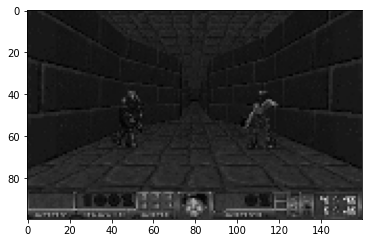

In [12]:
plt.imshow(cv2.cvtColor(state,cv2.COLOR_BGR2RGB))

In [13]:
env.step(2)

(array([[[32],
         [33],
         [25],
         ...,
         [27],
         [23],
         [24]],
 
        [[27],
         [33],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        [[20],
         [35],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 -40.0,
 False,
 {'health': 100.0, 'damage_taken': 0.0, 'hitcount': 0.0, 'ammo': 52.0})

In [18]:
env.close()

In [15]:
# ENVIRONMENT Checker
from stable_baselines3.common import env_checker

In [17]:
env_checker.check_env(env)

# 3. Setup Callback

In [19]:
import os
from stable_baselines3.common.callbacks import BaseCallback

In [20]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [21]:
CHECKPOINT_DIR = './train/train_corridor'
LOG_DIR = './logs/log_corridor'

In [22]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# 4 Train Model Using Curriculum

In [23]:
from stable_baselines3 import PPO

In [24]:
env = VizDoomGym(config='github/VizDoom/scenarios/deadly_corridor_s1.cfg')

In [26]:
model = PPO('CnnPolicy',env,tensorboard_log=LOG_DIR,verbose=1,learning_rate=0.00001,n_steps=8192, clip_range=0.1, gamma=0.95, gae_lambda=0.9)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(total_timesteps=400000,callback=callback)

In [28]:
env.close()

In [ ]:
env = VizDoomGym(config='github/VizDoom/scenarios/deadly_corridor_s2.cfg')
model.set_env(env)
model.learn(total_timesteps=40000,callback=callback)

# 6. Test the Model

In [29]:
from stable_baselines3.common.evaluation import evaluate_policy

In [30]:
model = PPO.load('./train/train_corridor/best_model_150000')

In [31]:
env = VizDoomGym(render=True)

In [32]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

C:\Users\ryanr\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [ ]:
for episode in range(5):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.05)
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)

In [35]:
env.close()